In [1]:
import numpy as np
import pandas as pd
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, load_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [3]:
train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8') # to save memory

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 5 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null uint8
vowel_diacritic        200840 non-null uint8
consonant_diacritic    200840 non-null uint8
grapheme               200840 non-null object
dtypes: object(2), uint8(3)
memory usage: 3.6+ MB


In [5]:
train_df.drop('grapheme', axis= 1, inplace= True)

In [6]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 4 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null uint8
vowel_diacritic        200840 non-null uint8
consonant_diacritic    200840 non-null uint8
dtypes: object(1), uint8(3)
memory usage: 2.1+ MB


In [8]:
train_imgs0 = pd.read_parquet("data/train_image_data_0.parquet")
train_imgs0.info()

In [9]:
train_imgs1 = pd.read_parquet("data/train_image_data_1.parquet")
train_imgs1.info()

In [10]:
train_imgs2 = pd.read_parquet("data/train_image_data_2.parquet")
train_imgs2.info()

In [11]:
train_imgs3 = pd.read_parquet("data/train_image_data_3.parquet")
train_imgs3.info()

In [12]:
train_imgs = pd.concat(
                    [train_imgs0, train_imgs1, train_imgs2, train_imgs3],
                    ignore_index= True)
train_imgs.info()

In [13]:
del train_imgs0, train_imgs1, train_imgs2, train_imgs3

In [14]:
img_id = train_imgs['image_id']

In [15]:
train_imgs.drop('image_id', axis= 1, inplace= True)

In [16]:
from data_functions import resize

In [ ]:
train_imgs_resized = resize(train_imgs)

In [18]:
del train_imgs

In [19]:
train_imgs_resized['image_id'] = img_id

In [20]:
train_df = train_df.merge(train_imgs_resized, on= 'image_id')
train_df.head()

In [21]:
train_df.info()

In [22]:
# pickle.dump(train_df, open('cleaned_training.p', 'wb'))

In [8]:
train_df = pickle.load(open('cleaned_training.p', 'rb'))

In [9]:
from data_functions import create_training_data

In [10]:
X, Y_root, Y_vowel, Y_consonant = create_training_data(train_df)

In [11]:
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X, Y_root, Y_vowel, Y_consonant, test_size=0.05, random_state=42)
y_train = [y_train_root, y_train_vowel, y_train_consonant]
y_test = [y_test_root, y_test_vowel, y_test_consonant]

In [16]:
inputs = Input(shape = (64, 64, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(64, 64, 1))(inputs)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
dense = Dense(1024, activation = "relu")(model)

root = Dense(168, activation = 'softmax')(dense)
vowel = Dense(11, activation = 'softmax')(dense)
consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[root, vowel, consonant])

In [17]:
from create_models import ModelEvaluation

In [18]:
mymodel = ModelEvaluation(model)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 32)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [19]:
mymodel.train(x_train, y_train,
              epochs= 32, 
              batch_size= 256, 
              validation_split= 0.1)

Train on 171718 samples, validate on 19080 samples
Epoch 1/32
171718/171718 [==============================] - 100s 583us/step - loss: 6.6393 - dense_6_loss: 4.3196 - dense_7_loss: 1.2597 - dense_8_loss: 1.0596 - dense_6_accuracy: 0.0915 - dense_7_accuracy: 0.6282 - dense_8_accuracy: 0.6977 - val_loss: 5.2226 - val_dense_6_loss: 3.7071 - val_dense_7_loss: 0.8131 - val_dense_8_loss: 0.7020 - val_dense_6_accuracy: 0.1490 - val_dense_7_accuracy: 0.7199 - val_dense_8_accuracy: 0.7563
Epoch 2/32
171718/171718 [==============================] - 99s 578us/step - loss: 4.7127 - dense_6_loss: 3.3517 - dense_7_loss: 0.7185 - dense_8_loss: 0.6424 - dense_6_accuracy: 0.2043 - dense_7_accuracy: 0.7511 - dense_8_accuracy: 0.7691 - val_loss: 4.5389 - val_dense_6_loss: 3.2170 - val_dense_7_loss: 0.7054 - val_dense_8_loss: 0.6167 - val_dense_6_accuracy: 0.2286 - val_dense_7_accuracy: 0.7605 - val_dense_8_accuracy: 0.7796
Epoch 3/32
171718/171718 [==============================] - 99s 579us/step - loss:

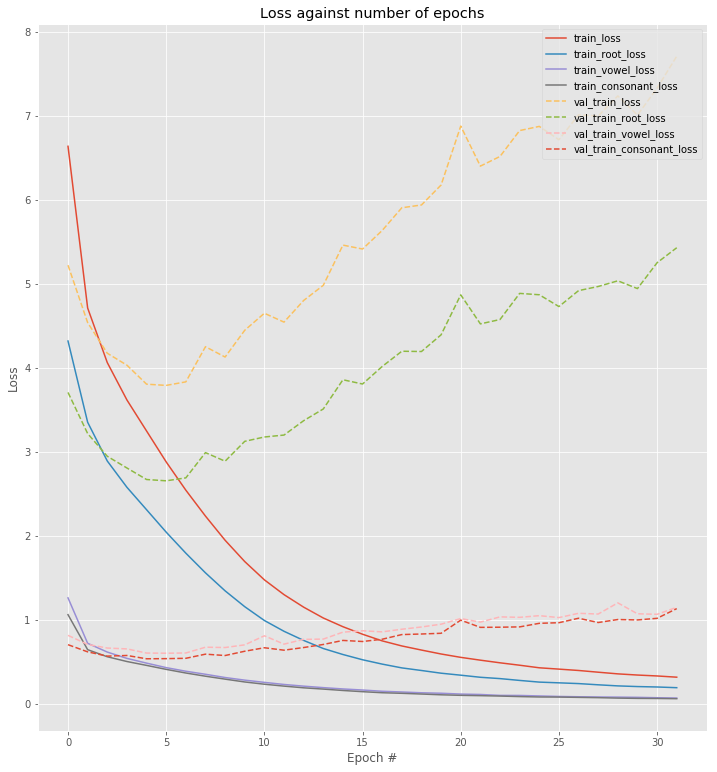

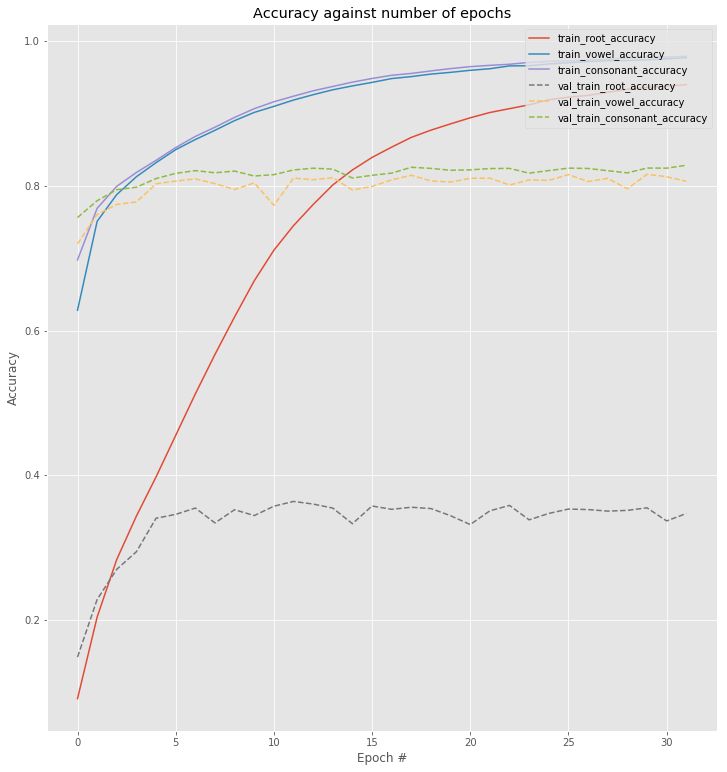

In [20]:
mymodel.plot_metrics()

In [21]:
mymodel.save_model()

In [22]:
mymodel.hist.history

{'dense_6_accuracy': [0.09152215,
  0.20428842,
  0.28395975,
  0.3438661,
  0.39793733,
  0.45529297,
  0.51260203,
  0.56718576,
  0.6190557,
  0.66884077,
  0.71114266,
  0.74508786,
  0.7742636,
  0.80133706,
  0.8220513,
  0.8393762,
  0.8536263,
  0.86706114,
  0.8770542,
  0.88574874,
  0.8941229,
  0.90144306,
  0.90676576,
  0.91203016,
  0.9190184,
  0.9226173,
  0.9250748,
  0.9293609,
  0.93343157,
  0.93642485,
  0.9378399,
  0.93985486],
 'dense_6_loss': [4.3195553,
  3.3517215,
  2.8901942,
  2.577128,
  2.3100705,
  2.04263,
  1.7923349,
  1.5578002,
  1.3434727,
  1.1546894,
  0.99025863,
  0.8616453,
  0.7528485,
  0.65648407,
  0.58504814,
  0.522496,
  0.47065163,
  0.42553994,
  0.39456385,
  0.36244816,
  0.33865514,
  0.3137993,
  0.29800478,
  0.27630302,
  0.25625643,
  0.2475792,
  0.23864764,
  0.22415173,
  0.21115713,
  0.20315725,
  0.19811432,
  0.18974173],
 'dense_7_accuracy': [0.6282452,
  0.75109774,
  0.7881352,
  0.8127162,
  0.8321259,
  0.8501147,

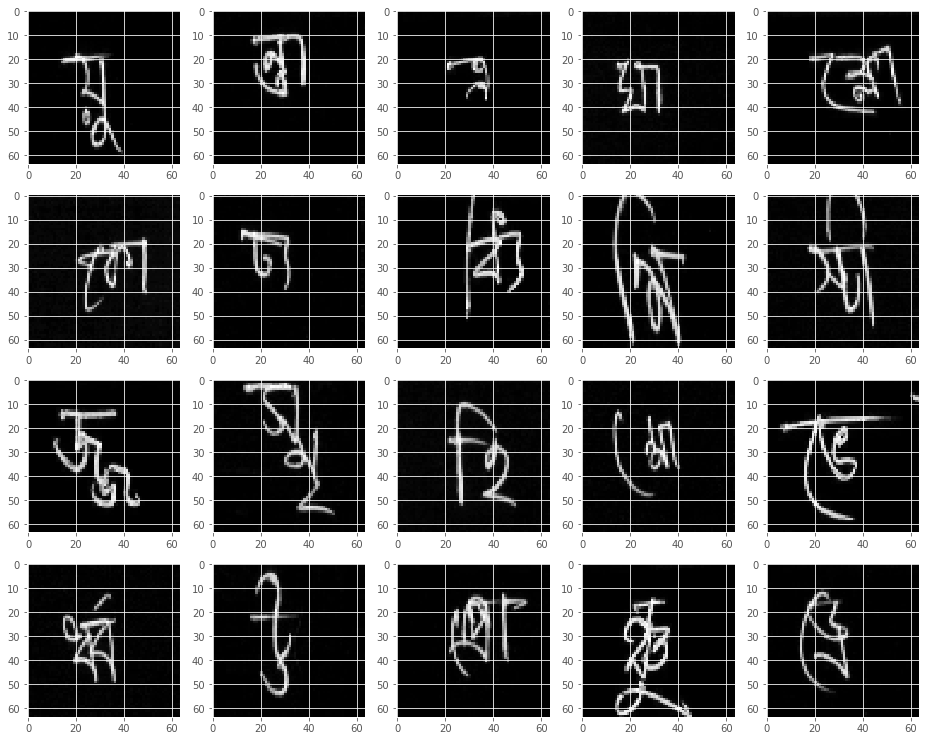

predicted                 true                
              root vowel consonant root vowel consonant
image_0        167     4         0  167     4         0
image_1         56     1         0   86     1         5
image_2         64     0         5   64     0         5
image_3         22     1         0   29     1         0
image_4        140     9         0   17     9         0
image_5        147     9         0   13     9         0
image_6        122     1         0   58     0         4
image_7         92     2         4   79     2         4
image_8         71     2         0  115     2         0
image_9        149     3         0  149     1         0
image_10        40     0         0   44     0         0
image_11       126     6         4  156     6         0
image_12       165     2         0  159     2         0
image_13       155     9         0   94     9         0
image_14       113     7         0  113     7         0
image_15       111     0         0   80     0         2
image_16        53     0         0   54     0         0
image_17        71     9         0   96     9         5
image_18        32     4         0   50     4         0
image_19        79     7         0   56     7         5

In [23]:
mymodel.test(x_test, y_test, 20)

In [24]:
mymodel.evaluation(x_test, y_test)

10042/10042 [==============================] - 4s 422us/step
[('loss', 7.584911671607909), ('dense_6_loss', 5.39757776260376), ('dense_7_loss', 1.1051106452941895), ('dense_8_loss', 1.0843908786773682), ('dense_6_accuracy', 0.3494323790073395), ('dense_7_accuracy', 0.8118900656700134), ('dense_8_accuracy', 0.8322047591209412)]
